# RoBERTa Classifier with IMSLP LM pretraining & finetuning

In this notebook we will train a RoBERTa classifier for the proxy task using the language model trained on IMSLP and finetuned on target data for initialization.  The language model is trained in 04_roberta_lm.ipynb.

This notebook is adapted from [this](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2) blog post.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [31]:
from fastai import *
from fastai.text import *
from transformers import RobertaForSequenceClassification, RobertaConfig
import eval_models
from train_utils import *

In [3]:
import fastai
import transformers
import tokenizers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print('tokenizers version :', tokenizers.__version__)

fastai version : 1.0.59
transformers version : 2.4.1
tokenizers version : 0.4.2


In [4]:
torch.cuda.set_device(1)

### Prep databunch

In [5]:
bs = 64
seed = 42
tok_model_dir = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/tokenizer_imslp'
max_seq_len = 256

In [6]:
cust_tok = CustomTokenizer(TransformersBaseTokenizer, tok_model_dir, max_seq_len)
transformer_base_tokenizer = TransformersBaseTokenizer(tok_model_dir, max_seq_len)
transformer_vocab =  TransformersVocab(tokenizer = transformer_base_tokenizer._pretrained_tokenizer)

In [7]:
pad_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('<pad>')

In [8]:
bpe_path = Path('/home/tjtsai/.fastai/data/bscore_lm/bpe_data')
train_df = pd.read_csv(bpe_path/'train64.char.csv')
valid_df = pd.read_csv(bpe_path/'valid64.char.csv')
test_df = pd.read_csv(bpe_path/'test64.char.csv')

In [9]:
data_clas = TextDataBunch.from_df(bpe_path, train_df, valid_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

### Train Classifier

In [10]:
model_class, config_class = RobertaForSequenceClassification, RobertaConfig
model_path = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/models/roberta_train-imslp_finetune-target_lm'

In [11]:
config = config_class.from_pretrained(model_path)
config.num_labels = data_clas.c

In [12]:
transformer_model = model_class.from_pretrained(model_path, config = config)
custom_transformer_model = RobertaModelWrapper(transformer_model, pad_idx)

In [ ]:
# learner.destroy()
# torch.cuda.empty_cache()

In [13]:
learner = Learner(data_clas, custom_transformer_model, metrics=[accuracy, FBeta(average='macro', beta=1)])

In [14]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.pooler]

In [15]:
learner.split(list_layers)
print(learner.layer_groups)

[Sequential(
  (0): Embedding(30000, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, o

In [16]:
seed_all(seed)

In [17]:
learner.freeze_to(-1)

In [ ]:
#learner.summary()

In [18]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-03
Min loss divided by 10: 6.31E-04


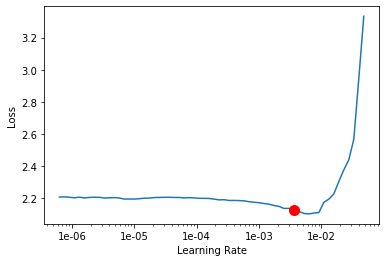

In [19]:
learner.recorder.plot(suggestion=True)

In [20]:
lr = 1e-3

In [21]:
learner.fit_one_cycle(4, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.590822,1.635231,0.382222,0.377562,00:54
1,1.473060,1.541298,0.413889,0.397679,00:55
2,1.386882,1.480440,0.437407,0.431059,00:56
3,1.317412,1.447153,0.457593,0.449544,00:56


In [22]:
learner.fit_one_cycle(3, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.396801,1.539481,0.421944,0.416182,00:54
1,1.296097,1.494364,0.442500,0.427928,00:56
2,1.201395,1.439742,0.464074,0.457803,00:55


In [23]:
learner.freeze_to(-2)
learner.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.228680,1.623721,0.441204,0.430183,01:04
1,0.754933,1.455576,0.511296,0.506826,01:06


In [24]:
learner.freeze_to(-3)
learner.fit_one_cycle(3, slice(lr/2/(2.6**4),lr/2), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.718179,1.748369,0.469815,0.467345,01:19
1,0.356007,1.761905,0.521204,0.513521,01:19
2,0.132951,1.919373,0.532870,0.529592,01:20


In [25]:
learner.save('roberta_train-imslp_finetune-target_clas')
#learner.load('roberta_train-imslp_finetune-target_clas')

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [26]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_df, test_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

In [27]:
learner.validate(data_clas_test.valid_dl)

[1.8427405, tensor(0.5526), tensor(0.5525)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.

In [28]:
train_fullpage_df = pd.read_csv(bpe_path/'train.fullpage.char.csv')
valid_fullpage_df = pd.read_csv(bpe_path/'valid.fullpage.char.csv')
test_fullpage_df = pd.read_csv(bpe_path/'test.fullpage.char.csv')

In [29]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df,
                                       tokenizer=cust_tok, vocab=transformer_vocab, include_bos=False, 
                                       include_eos=False, pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [32]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df, databunch=data_clas_test)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.6441717743873596, 0.6518405079841614),
 (0.6274559872998429, 0.6283874444872694))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [33]:
test_ensemble_df = pd.read_csv(bpe_path/'test.ensemble64.char.csv')

In [34]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df,
                                       text_cols = 'text', label_cols = 'label', tokenizer=cust_tok, 
                                       vocab=transformer_vocab, include_bos=False, include_eos=False, 
                                       pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [36]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, databunch=data_clas_test, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.678680956363678, 0.6472392678260803),
 (0.6423711069232394, 0.59317538342032))

### Error Analysis

In [37]:
interp = ClassificationInterpretation.from_learner(learner)

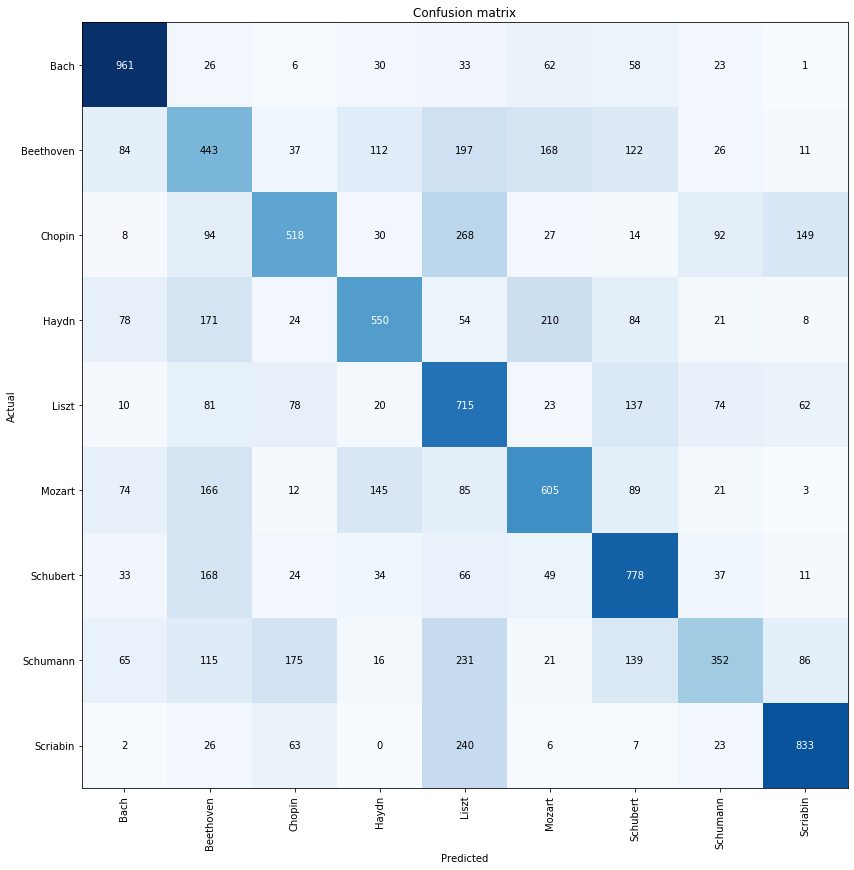

In [38]:
interp.plot_confusion_matrix(figsize=(12,12))